# <center>Subitization Model</center>

### Calling Dependencies

In [21]:
import nest
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma

### Nest Simulator Useful Functions

```nest.ResetKernel()``` &rarr; To reset the simulation and connections

### Understanding the Integrate and Fire Model Used in Nest Simulator

The following code will be used for testing the ```iaf_psc_alpha model``` given by nest simulator. This is a leaky integrate-and-fire model with alpha shaped input currents, where the input current is constant. It is a leaky integrate and fire neuron model with:
* a hard threshold
* a fixed refractory period
* no adaptation mechanism
* $\alpha$-shaped synaptic input currents.

#### Explanation of iaf_psc_alpha code

**The ```integrate and fire model```:**

$\tau_{\text{m}}\frac{dV_\text{m}}{dt} = -(V_{\text{m}} - E_\text{L})+ RI$

where:\
&emsp;$ I = I_{\text{syn}} + I_\text{e}$\
&emsp;$ I_{\text{syn}}$ &rarr; input current from pre-synaptic neurons\
&emsp;$I_\text{e}$ &rarr; constant input current\
&emsp;$R$ &rarr; resistance of the circuit\
&emsp;$V_\text{m}$ &rarr; membrance potential \
&emsp;$E_\text{L}$ &rarr; resting membrance potential\
&emsp;$\tau_{\text{m}}$ &rarr; membrane decay constant


A spike is emitted at timestep $t^*=t_{k+1}$ if:

$V_\text{m}(t_k) < V_{th} \quad\text{and}\quad V_\text{m}(t_{k+1})\geq V_\text{th} \;$

This membrane potential will be clamped to $V_{\text{reset}} where the refractory period is defined as $t_{\text{ref}}$:\
$V_\text{m}(t) = V_{\text{reset}} \quad\text{for}\quad t^* \leq t < t^* + t_{\text{ref}} \;,$

**Calculating the Synaptic Input, $I_{\text{syn}}$:**

$I_{\text{syn}}(t) = I_{\text{syn, ex}}(t) + I_{\text{syn, in}}(t)$

and

$I_{\text{syn, X}}(t) = \sum_{j} w_j \sum_k i_{\text{syn, X}}(t-t_j^k-d_j) \;,$

where:\
&emsp;$ I_{\text{syn, ex}}(t)$ &rarr; excitatory synaptic input\
&emsp;$ I_{\text{syn, in}}(t)$ &rarr; inhibitory synaptic input\
&emsp;$ j$ &rarr; $j$ is used to define for $\text{X}$ ($\text{X} \in \{I_{\text{syn, ex}}, I_{\text{syn, in}}(t)\}$)\
&emsp;$ k$ &rarr; indexes the spikes times of pre-synaptic neuron $j$\
&emsp;$ d_j$ &rarr; delay from pre-synaptic neuron $j$

**The post-synaptic currents are given by:**

$i_{\text{syn, X}}(t) = \frac{e}{\tau_{\text{syn, X}}} t e^{-\frac{t}{\tau_{\text{syn, X}}}} \Theta(t)$

where:\
&emsp;$Theta(t)$ &rarr; the heaviside step function. The PSCs are normalized to unit maximum, i.e., $i_{\text{syn, X}}(t= \tau_{\text{syn, X}}) = 1 \;.$

As a consequence, the total charge $q$ transferred by a single PSC depends on the synaptic time constant according to

$q = \int_0^{\infty}  i_{\text{syn, X}}(t) dt = e \tau_{\text{syn, X}} \;.$

By default, $V_\text{m}$ is not bounded from below. To limit
hyperpolarization to biophysically plausible values, set parameter
$V_{\text{min}}$ as lower bound of $V_\text{m}$.

#### Nest Simulation for Single Neuron with Constant Input Current

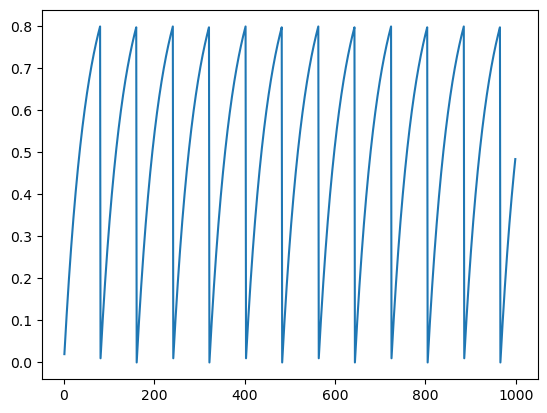

In [22]:
# Parameters
# Neuron parameters
parameters = {
        "V_m": 0,                   # mV
        "E_L": 0,                   # mV
        "V_th": 0.8,                # mV
        "V_reset": 0,               # mV
        "tau_syn_ex": 1000,         # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 10 ** 12,            # pA input current
        "tau_m": 50,                # ms membrane time constant
        "C_m": (50) * 10**12,       # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                  # ms refractory period
    }

# Reset Network
nest.ResetKernel()

# Initialise neurons
neuron = nest.Create('iaf_psc_alpha', params = parameters)
spike_recorder = nest.Create('spike_recorder')
multimeter = nest.Create('multimeter')
multimeter.set(record_from=["V_m"])

# Synapse Connection Management
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spike_recorder)

# Simulation
nest.Simulate(1000)

# Plot
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
events = spike_recorder.get("events")
senders = events["senders"]
plt.figure(1)
plt.plot(ts,Vms)
plt.show()

#### Nest Simulator for Single Neuron with Different Noise

The three methods to test here are the use of Poisson Generator, Noise Generator (input current with a Gaussian Distribution), and manually changing the input current from the parameters.

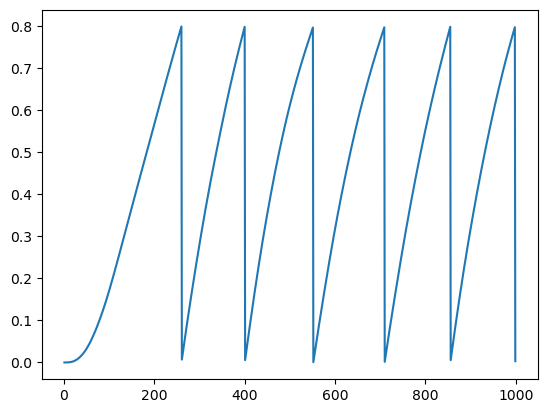

In [23]:
# Paramters
# neuron parameters
parameters = {
        "V_m": 0,                   # mV
        "E_L": 0,                   # mV
        "V_th": 0.8,                # mV
        "V_reset": 0,               # mV
        "tau_syn_ex": 50,           # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 0 * (10 ** 6),       # pA input current
        "tau_m": 200,               # ms membrane time constant
        "C_m": 70 * 10**6,          # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                  # ms refractory period
    }
# poisson generator params
poi_param = {
    "rate": 2000.0   # Hz rate of poisson generator
}
# noise generator params
white_param = {
    "mean": 0 * (10**12),  # pA mean value of the noise current
    "std": 0.5 * (10**12)  # pA the standard deviation of the noise current
}

# Testing Poisson Generator
# Reset Network (this includes the connections)
nest.ResetKernel()

# Initialise Neurons
poi_gen = nest.Create('poisson_generator', params=poi_param)
neuron = nest.Create('iaf_psc_alpha', params=parameters)
spike_recorder = nest.Create('spike_recorder')
multimeter = nest.Create('multimeter')
multimeter.set(record_from=["V_m"])

# Synapse Connection Management
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spike_recorder)
nest.Connect(poi_gen, neuron, syn_spec={'weight': 2 * 10**3})

# Simulate
nest.Simulate(1000)

# Plot
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
events = spike_recorder.get("events")
senders = events["senders"]
plt.figure(1)
plt.plot(ts,Vms)
plt.show()

# # Testing Noise Generator
# # Reset Network
# nest.ResetKernel()

# # Initialise Neurons
# white_gen = nest.Create('noise_generator', params=white_param)
# neuron = nest.Create('iaf_psc_alpha', params=parameters)
# spike_recorder = nest.Create('spike_recorder')
# multimeter = nest.Create('multimeter')
# multimeter.set(record_from=["V_m"])

# # Synapse Connection Management
# nest.Connect(multimeter, neuron)
# nest.Connect(neuron, spike_recorder)
# nest.Connect(white_gen, neuron)

# # Simulate
# nest.Simulate(1000)

# # Plot
# dmm = multimeter.get()
# Vms = dmm["events"]["V_m"]
# ts = dmm["events"]["times"]
# events = spike_recorder.get("events")
# senders = events["senders"]
# plt.figure(1)
# plt.plot(ts,Vms)
# plt.show()

#### Process With Input Current
The following code creates a single neuron that has an input current. The neuron's activity is adjusted based on the input current and capacitance. \
Units for function parameters:
* current: A
* capacitance: F

In [24]:
def test_current(current, capacitance):
    parameters = {
            "V_m": 0,                   # mV
            "E_L": 0,                   # mV
            "V_th": 0.8,                # mV
            "V_reset": 0,               # mV
            "tau_syn_ex": 1000,         # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            "I_e": current * (10 ** 6), # pA input current
            "tau_m": 50,                # ms membrane time constant
            "C_m": capacitance * 10**6, # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                  # ms refractory period
        }

    # Reset Network
    nest.ResetKernel()

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"]), multimeter.get()

#### Plotting Test Based On Current and Capacitance

As we increase the capacitance it requires more current to be injected. This acts like a form of threshold. \
The current tested: [0 to 100]

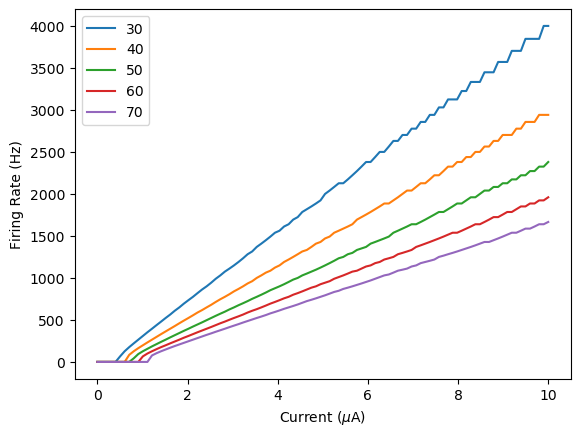

In [25]:
plt.figure()
test_range = np.linspace(0,10,100)
for c in range(30, 80, 10):
    record_fr = np.empty(0)
    for i in test_range:
        fr, _ = test_current(i, c)
        record_fr = np.append(record_fr, fr)
    plt.plot(test_range, record_fr, label=str(c))
plt.legend()
plt.xlabel("Current ($\mu$A)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Process With Poisson Generator
The following code creates a single neuron that has a single poisson generator input. This generator can be adjusted based on its rate and the connectivity of the poisson generator to the single neuron can be adjusted based on its weight.

In [33]:
def test_random_generator(rate, weight):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": 50,                    # ms membrane time constant
            "C_m": 26 * 10**6,              # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': weight * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"]), multimeter.get()


#### Plotting Test Based On Poisson Generator input
The following test will determine the firing rate based on the rate generated by a Poisson generator.
The Poisson generator rate tested: [0 to 1000]

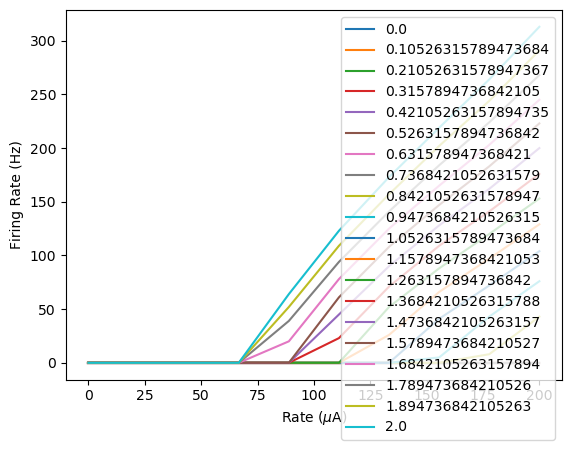

In [40]:
plt.figure()
rate_range = np.linspace(0, 200, 10)
weight_range = np.linspace(0, 2, 20)
for w in weight_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_random_generator(r, w)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(w))
plt.legend()
plt.xlabel("Rate ($\mu$A)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### How capacitance affect the fr to input ratio

In [42]:
def test_capacitance_generator(capacitance, rate):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": 50,                    # ms membrane time constant
            "C_m": capacitance * 10**6,     # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': 1.2 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"]), multimeter.get()



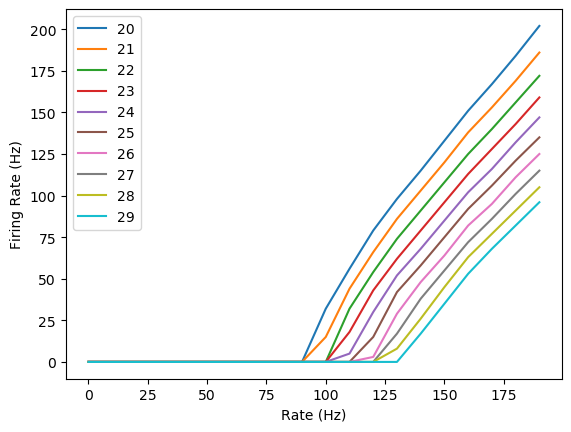

In [45]:
plt.figure()
capacitance_range = range(20,30,1)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for c in capacitance_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_capacitance_generator(c, r)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(c))
plt.legend()
plt.xlabel("Rate (Hz)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Test Tau

The capacitance and rate will determine how fast the model's rate can go up. In this case, I will be using the tau function to determine whether we can get a RELU like function. The idea is that when the input between two neurons cannot reach a certain threshold, this will not raise the spike at all.

In [47]:
def test_tau_generator(tau_m, rate):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": tau_m,                    # ms membrane time constant
            "C_m": 20 * 10**6,     # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': 1.2 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"]), multimeter.get()



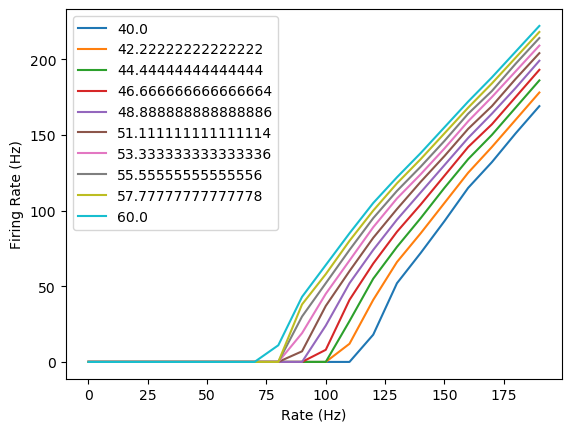

In [51]:
plt.figure()
tau_range = np.linspace(40, 60, 10)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for tau in tau_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_tau_generator(tau, r)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(tau))
plt.legend()
plt.xlabel("Rate (Hz)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### The following parameters will be used for the neuron where gain modulation is implemented to transfer spikes.
    "V_m": 0,                       # mV
    "E_L": 0,                       # mV
    "V_th": 0.8,                    # mV
    "V_reset": 0,                   # mV
    "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
    # "I_e": current * (10 ** 6),   # pA input current (commented)
    "I_e": 0,                       # pA input current
    "tau_m": 53,                    # ms membrane time constant
    "C_m": 20 * 10**6,              # pF membrane capacitance (calculated for R = 1)
    "t_ref": 0                      # ms refractory period

#### Use of two poisson generator as input to determine whether the spike can rise or not

In [52]:
def test_gain_mod(rate1, rate2, weight1, weight2):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": 53,                    # ms membrane time constant
            "C_m": 20 * 10**6,     # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param_1 = {
        "rate": rate1   # Hz rate of poisson generator
    }

    poi_param_2 = {
        "rate": rate2   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen1 = nest.Create('poisson_generator', params=poi_param_1)
    poi_gen2 = nest.Create('poisson_generator', params=poi_param_2)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen1, neuron, syn_spec={'weight': weight1 * 10**3})
    nest.Connect(poi_gen2, neuron, syn_spec={'weight': weight2 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()



In [57]:
fig, axs = plt.subplots(10,10)
max_range = 200
min_range = 0
no_of_test = 21
w1_list = np.linspace(0.1, 1, 10)
w2_list = np.linspace(0.1, 1, 10)
for w1 in range(10):
    for w2 in range(10):
        print(w1_list[w1],w2_list[w2])
        rate1_range = np.linspace(max_range,min_range, no_of_test)
        rate2_range = np.linspace(min_range,max_range, no_of_test)
        record_fr = np.empty((len(rate1_range), len(rate2_range)))
        for r1_i in range(len(rate1_range)):
            for r2_i in range(len(rate2_range)):
                fr, _ = test_gain_mod(rate1_range[r1_i], rate2_range[r2_i], w1_list[w1], w2_list[w2])
                record_fr[r1_i][r2_i] = fr
        img = axs[w1, w2].imshow(record_fr)
        axs[w1, w2].set_xticks(np.linspace(0, no_of_test,5))
        axs[w1, w2].set_yticks(np.linspace(0, no_of_test,5))
        axs[w1, w2].set_xticklabels(np.linspace(min_range, max_range, 5))
        axs[w1, w2].set_yticklabels(labels = np.linspace(max_range, min_range, 5))
plt.show()

0.1 0.1
0.1 0.2
0.1 0.30000000000000004
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7000000000000001
0.1 0.8
0.1 0.9
0.1 1.0
0.2 0.1
0.2 0.2
0.2 0.30000000000000004
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7000000000000001
0.2 0.8


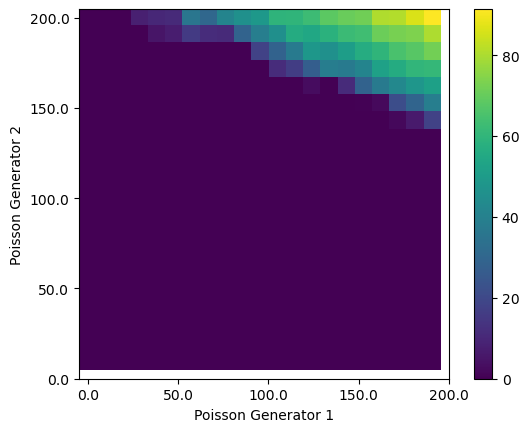

In [ ]:
rate1_range = np.linspace(max_range,min_range, no_of_test)
rate2_range = np.linspace(min_range,max_range, no_of_test)
record_fr = np.empty((len(rate1_range), len(rate2_range)))
for r1_i in range(len(rate1_range)):
    for r2_i in range(len(rate2_range)):
        fr, _ = test_gain_mod(rate1_range[r1_i], rate2_range[r2_i], 5, 2)
        record_fr[r1_i][r2_i] = fr
plt.figure()
plt.imshow(record_fr)
plt.xlabel("Poisson Generator 1")
plt.ylabel("Poisson Generator 2")
plt.xticks(ticks=np.linspace(0, no_of_test,5), labels=np.linspace(min_range, max_range, 5))
plt.yticks(ticks=np.linspace(0, no_of_test,5), labels=np.linspace(max_range, min_range, 5))
plt.colorbar()
plt.show()

#### Explanation on Gain Modulation

Referece: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2887717/

Non-linear way in which neurons combine information from two (or more) sources. It can modulate the sensitivity of neuron's input without changing the selectivity or receptive field properties.

In this case we compute the activity for the gain fields as follow:

$r = f(x_{target} - a) g(x_{perception}) $

where:\
$r = \text{amplitude response of the neuron}$ \
$x_{target} = \text{activity from a neuron in the ring attractor}$ \
$x_{perception} =\text{activity from homeostatis model}$